# maxvogt-analysis: Winterthur-Seen

The code in this notebook is based on [Martin Fleischmann's](https://martinfleischmann.net/) 2021 workshop [*Capturing the Structure of Cities with Data Science (SDSC)*](https://github.com/martinfleis/sdsc21-workshop), licensed under the [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). © 2021 Martin Fleischmann.

The geodata in this notebook is retrieved from OpenStreetMap. © OpenStreetMap Contributors.

<hr>

This notebook contains geodata and analyses for the following items of the [Max Vogt collection](https://mtwente.github.io/maxvogt/) by Moritz Twente and Luisa Omonsky:
- [WSEE015](https://mtwente.github.io/maxvogt/items/wsee015.html)

<hr>

Open in an interactive in-browser environment: 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mtwente/maxvogt-analysis/main?labpath=analysis%2Fseen.ipynb)

In [1]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [2]:
place = 'Seen, Winterthur'
local_crs = 'EPSG:2056'

In [3]:
geopandas.tools.geocode(place).explore()

## Input data

Download data from OpenStreetMap.

### Buildings

In [4]:
buildings = osmnx.features.features_from_place(place, tags={'building':True})

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/sit

In [5]:
buildings

geometry  \
element_type osmid                                                           
way          38674730    POLYGON ((8.76493 47.49146, 8.76487 47.49148, ...   
             52810255    POLYGON ((8.76025 47.46530, 8.76035 47.46530, ...   
             54707169    POLYGON ((8.75901 47.46732, 8.75905 47.46722, ...   
             54707179    POLYGON ((8.75951 47.46727, 8.75968 47.46724, ...   
             54707192    POLYGON ((8.75879 47.46671, 8.75882 47.46671, ...   
...                                                                    ...   
             1291917556  POLYGON ((8.79690 47.47668, 8.79689 47.47667, ...   
             1291917559  POLYGON ((8.79868 47.47664, 8.79870 47.47662, ...   
             1304423835  POLYGON ((8.75987 47.46285, 8.75989 47.46285, ...   
             1304454222  POLYGON ((8.75618 47.46835, 8.75620 47.46836, ...   
             1315560153  POLYGON ((8.77526 47.48468, 8.77527 47.48450, ...   

                        addr:housenumber             addr:street access  \
element_type osmid                                                        
way          38674730                NaN                     NaN    NaN   
             52810255                377          Tösstalstrasse    NaN   
             54707169                  3        Linsentalstrasse    NaN   
             54707179                360          Tösstalstrasse    NaN   
             54707192                  2  Hermann-Bühler-Strasse    NaN   
...                                  ...                     ...    ...   
             1291917556              5.1           Lehmgrubenweg    NaN   
             1291917559                1       Chälenrainstrasse    NaN   
             1304423835              NaN                     NaN    NaN   
             1304454222              NaN                     NaN    NaN   
             1315560153                6              Im Stuckli    NaN   

                            amenity   addr:city addr:postcode wheelchair  \
element_type osmid                                                         
way          38674730           NaN         NaN           NaN        NaN   
             52810255           NaN         NaN           NaN        NaN   
             54707169           NaN         NaN           NaN        NaN   
             54707179    restaurant         NaN           NaN         no   
             54707192           NaN     Sennhof          8405        NaN   
...                             ...         ...           ...        ...   
             1291917556         NaN  Winterthur          8405        NaN   
             1291917559         NaN  Winterthur          8405        NaN   
             1304423835         NaN         NaN           NaN        NaN   
             1304454222         NaN         NaN           NaN        NaN   
             1315560153         NaN  Winterthur          8405        NaN   

                                                                     nodes  \
element_type osmid                                                           
way          38674730    [1529968276, 458165511, 458165518, 458165488, ...   
             52810255    [669815152, 1352615824, 6058470767, 6058470766...   
             54707169    [734879895, 691126832, 688827419, 688827420, 6...   
             54707179    [688827421, 688827422, 688827423, 688827424, 1...   
             54707192    [688827425, 715702757, 715702532, 715702119, 7...   
...                                                                    ...   
             1291917556  [11976660316, 11976660315, 11976660314, 119766...   
             1291917559  [11976660337, 11976660339, 11976660340, 119766...   
             1304423835  [12079867158, 12079867157, 12079867156, 120798...   
             1304454222  [12080174905, 12080174904, 12080174903, 120801...   
             1315560153  [12177117096, 12177117097, 12177117098, 121771...   

                                building  ... contact:email contact:pho

In [6]:
buildings.geom_type.value_counts()

Polygon    4197
Name: count, dtype: int64

In [7]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [8]:
buildings = buildings[["geometry"]].to_crs(local_crs)

In [9]:
buildings["uID"] = range(len(buildings))

In [10]:
buildings

geometry   uID
0     POLYGON ((2699945.517 1260922.024, 2699940.626...     0
1     POLYGON ((2699641.457 1258008.113, 2699649.433...     1
2     POLYGON ((2699544.853 1258231.180, 2699547.567...     2
3     POLYGON ((2699582.050 1258225.401, 2699595.355...     3
4     POLYGON ((2699529.347 1258163.264, 2699531.564...     4
...                                                 ...   ...
4192  POLYGON ((2702382.817 1259320.289, 2702382.103...  4192
4193  POLYGON ((2702517.116 1259317.923, 2702518.289...  4193
4194  POLYGON ((2699617.986 1257734.786, 2699619.230...  4194
4195  POLYGON ((2699328.883 1258341.430, 2699331.099...  4195
4196  POLYGON ((2700736.378 1260181.718, 2700737.756...  4196

[4197 rows x 2 columns]

### Streets

In comparison to Martin Fleischmann's workshop, I here set `truncate_by_edge` to be `True`.
Depending on the OSM mapping quality of the place at hand, it might also be necessary to change the value of `network_type`. See [geopandas documentation](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.graph.graph_from_place) for options.

In [15]:
osm_graph = osmnx.graph_from_place(place, network_type='drive_service', truncate_by_edge=True)

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [16]:
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)

In [17]:
streets = osmnx.graph_to_gdfs(
    osm_graph, 
    nodes=False, 
    edges=True,
    node_geometry=False, 
    fill_edge_geometry=True
)

In [18]:
streets.explore()

In [19]:
streets

osmid               name      highway  \
u           v           key                                               
25426789    3433910722  0       4264252    Grünmattstrasse  residential   
            25430705    0      47657081  Oberseenerstrasse  residential   
            6923946426  0      47657081  Oberseenerstrasse  residential   
3433910722  3433910726  0       4264252    Grünmattstrasse  residential   
            25426789    0       4264252    Grünmattstrasse  residential   
...                                 ...                ...          ...   
10824661612 10824661609 0    1163920264                NaN      service   
11484293453 11484293451 0    1236743403                NaN      service   
11492760501 11492760502 0    1237387486                NaN      service   
11492760550 11492777866 0    1237387487                NaN      service   
11492777842 11492777843 0    1237387494                NaN      service   

                            maxspeed  oneway reversed   length  \
u           v           key                                      
25426789    3433910722  0         30   False    False   11.438   
            25430705    0         30   False    False  227.947   
            6923946426  0         30   False     True   50.728   
3433910722  3433910726  0         30   False    False   36.065   
            25426789    0         30   False     True   11.438   
...                              ...     ...      ...      ...   
10824661612 10824661609 0        NaN   False     True   19.850   
11484293453 11484293451 0        NaN   False     True   14.973   
11492760501 11492760502 0        NaN   False     True   26.546   
11492760550 11492777866 0        NaN   False     True   47.389   
11492777842 11492777843 0        NaN   False     True    8.179   

                                                                      geometry  \
u           v           key                                                      
25426789    3433910722  0    LINESTRING (2700098.410 1259801.192, 2700104.1...   
            25430705    0    LINESTRING (2700098.410 1259801.192, 2700191.5...   
            6923946426  0    LINESTRING (2700098.410 1259801.192, 2700080.2...   
3433910722  3433910726  0    LINESTRING (2700106.498 1259809.246, 2700111.5...   
            25426789    0    LINESTRING (2700106.498 1259809.246, 2700104.1...   
...                                                                        ...   
10824661612 10824661609 0    LINESTRING (2700169.723 1259414.939, 2700172.5...   
11484293453 11484293451 0    LINESTRING (2699501.589 1258253.893, 2699501.0...   
11492760501 11492760502 0    LINESTRING (2700770.971 1257977.364, 2700745.2...   
11492760550 11492777866 0    LINESTRING (2700225.801 1257961.251, 2700251.5...   
11492777842 11492777843 0    LINESTRING (2700390.156 1257894.471, 2700391.3...   

                              service junction lanes  ref tunnel width bridge  \
u           v           key                                                     
25426789    3433910722  0         NaN      NaN   NaN  NaN    NaN   NaN    NaN   
            25430705    0         NaN      NaN   NaN  NaN    NaN   NaN    NaN   
            6923946426  0         NaN      NaN   NaN  NaN    NaN   NaN    NaN   
3433910722  3433910726  0         NaN      NaN   NaN  NaN    NaN   NaN    NaN   
            25426789    0         NaN      NaN   NaN  NaN    NaN   NaN    NaN   
...                               ...      ...   ...  ...    ...   ...    ...   
10824661612 10824661609 0    driveway      NaN   NaN  NaN    NaN   NaN    NaN   
11484293453 11484293451 0    driveway      NaN   NaN  NaN    NaN   NaN    NaN   
11492760501 11492760502 0    driveway      NaN   NaN  NaN    NaN   NaN    NaN   
11492760550 11492777866 0    driveway      NaN   NaN  NaN    NaN   NaN    NaN   
11492777842 11492777843 0    driveway      NaN   NaN  NaN    NaN   NaN    NaN   

                            access  
u           v           key         
2542

In [20]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

In [21]:
streets

geometry   nID
0     LINESTRING (2700098.410 1259801.192, 2700104.1...     0
1     LINESTRING (2700098.410 1259801.192, 2700191.5...     1
2     LINESTRING (2700098.410 1259801.192, 2700080.2...     2
3     LINESTRING (2700106.498 1259809.246, 2700111.5...     3
4     LINESTRING (2700106.498 1259809.246, 2700104.1...     4
...                                                 ...   ...
1025  LINESTRING (2702187.309 1259059.062, 2702179.5...  1025
1026  LINESTRING (2702215.290 1259140.946, 2702223.9...  1026
1027  LINESTRING (2702290.266 1259072.708, 2702285.9...  1027
1028  LINESTRING (2702369.765 1260458.589, 2702358.8...  1028
1029  LINESTRING (2702386.913 1260310.630, 2702379.6...  1029

[1030 rows x 2 columns]

## Generated data

### Tessellation

We can generate a spatail unit using Voronoi tessellation with given building footprints.

In [22]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/1328706492.py:3: FutureWarning: Class based API like `momepy.Tessellation` is deprecated. Replace it with `momepy.morphological_tessellation` or `momepy.enclosed_tessellation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/m

### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [23]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")

In [24]:
buildings

geometry   uID  index_right  \
0     POLYGON ((2699945.517 1260922.024, 2699940.626...     0          900   
1     POLYGON ((2699641.457 1258008.113, 2699649.433...     1          866   
2     POLYGON ((2699544.853 1258231.180, 2699547.567...     2          556   
2     POLYGON ((2699544.853 1258231.180, 2699547.567...     2          551   
3     POLYGON ((2699582.050 1258225.401, 2699595.355...     3          556   
...                                                 ...   ...          ...   
4193  POLYGON ((2702517.116 1259317.923, 2702518.289...  4193          595   
4193  POLYGON ((2702517.116 1259317.923, 2702518.289...  4193          568   
4194  POLYGON ((2699617.986 1257734.786, 2699619.230...  4194          885   
4195  POLYGON ((2699328.883 1258341.430, 2699331.099...  4195          827   
4196  POLYGON ((2700736.378 1260181.718, 2700737.756...  4196          978   

      nID  
0     900  
1     866  
2     556  
2     551  
3     556  
...   ...  
4193  595  
4193  568  
4194  885  
4195  827  
4196  978  

[5719 rows x 4 columns]

In [25]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")

In [26]:
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Measure

Measure individual morphometric characters.

### Dimensions

In [27]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [28]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/1902756608.py:1: FutureWarning: Class based API like `momepy.EquivalentRectangularIndex` is deprecated. Replace it with `momepy.equivalent_rectangular_index` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [29]:
buildings['elongation'] = momepy.Elongation(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/3723954296.py:1: FutureWarning: Class based API like `momepy.Elongation` is deprecated. Replace it with `momepy.elongation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['elongation'] = momepy.Elongation(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [30]:
tessellation['convexity'] = momepy.Convexity(tessellation).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/2335586521.py:1: FutureWarning: Class based API like `momepy.Convexity` is deprecated. Replace it with `momepy.convexity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation['convexity'] = momepy.Convexity(tessellation).series


In [31]:
streets["linearity"] = momepy.Linearity(streets).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/3802614628.py:1: FutureWarning: Class based API like `momepy.Linearity` is deprecated. Replace it with `momepy.linearity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  streets["linearity"] = momepy.Linearity(streets).series


/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


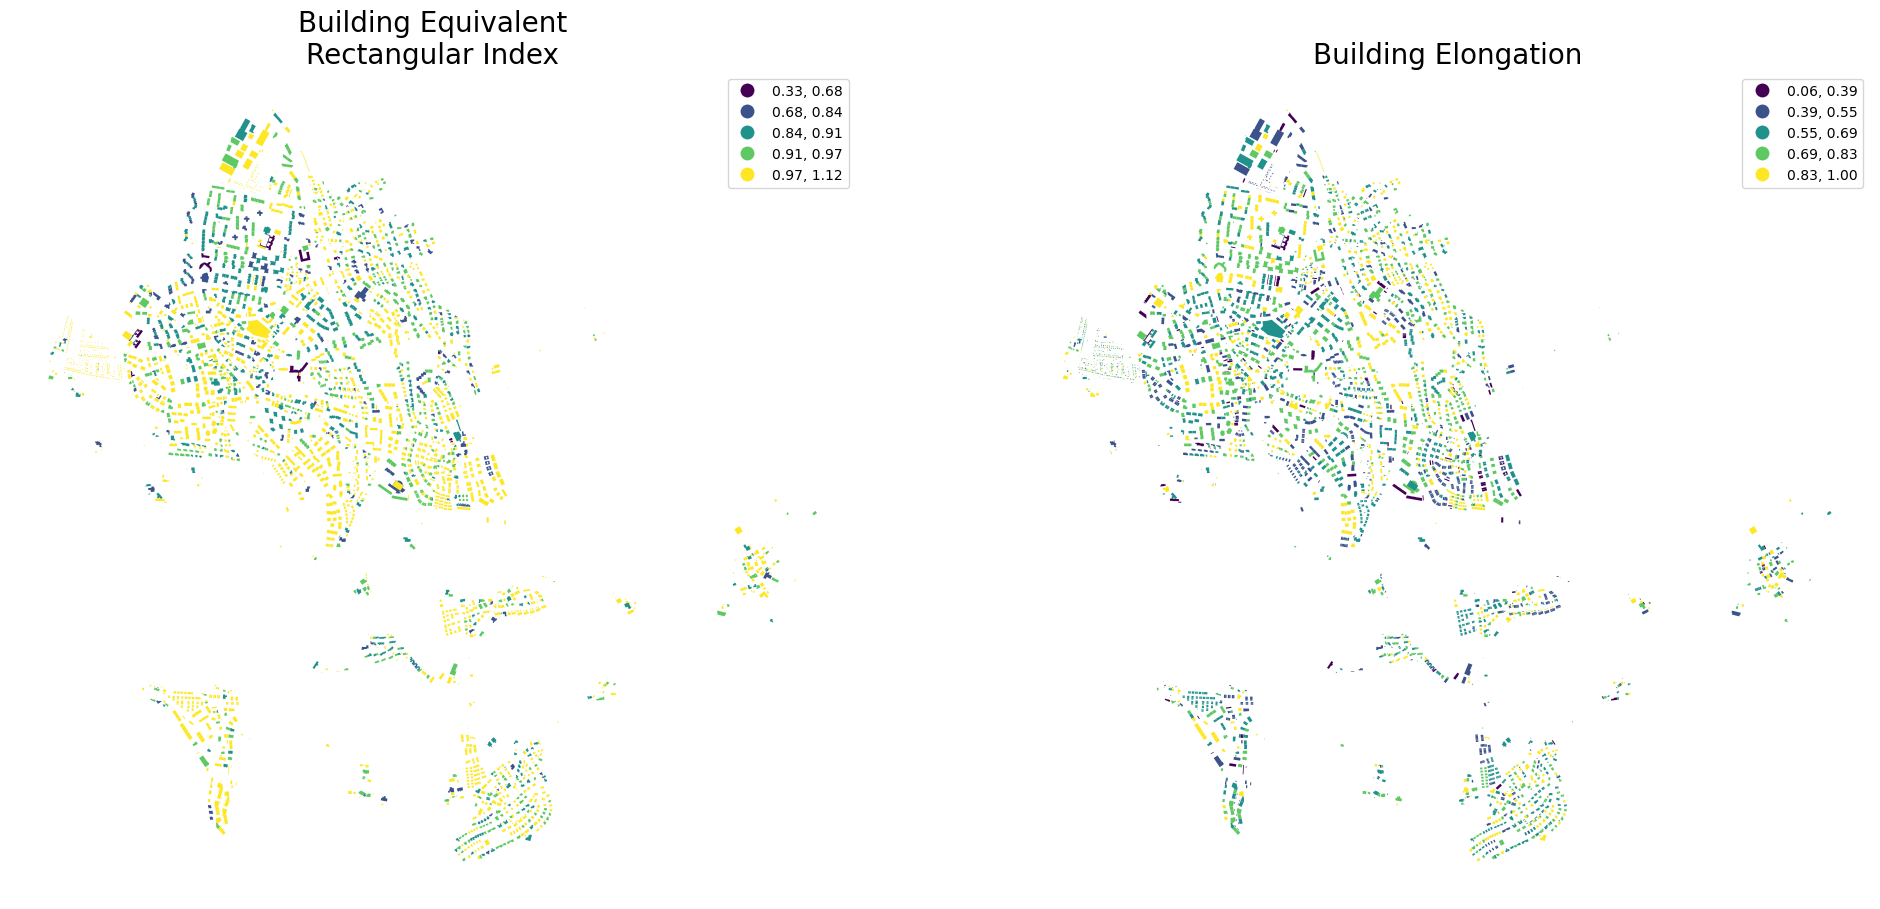

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Building Equivalent\nRectangular Index', fontsize=20)
ax[1].set_title('Building Elongation', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Seen/eri_and_elongation.svg')  

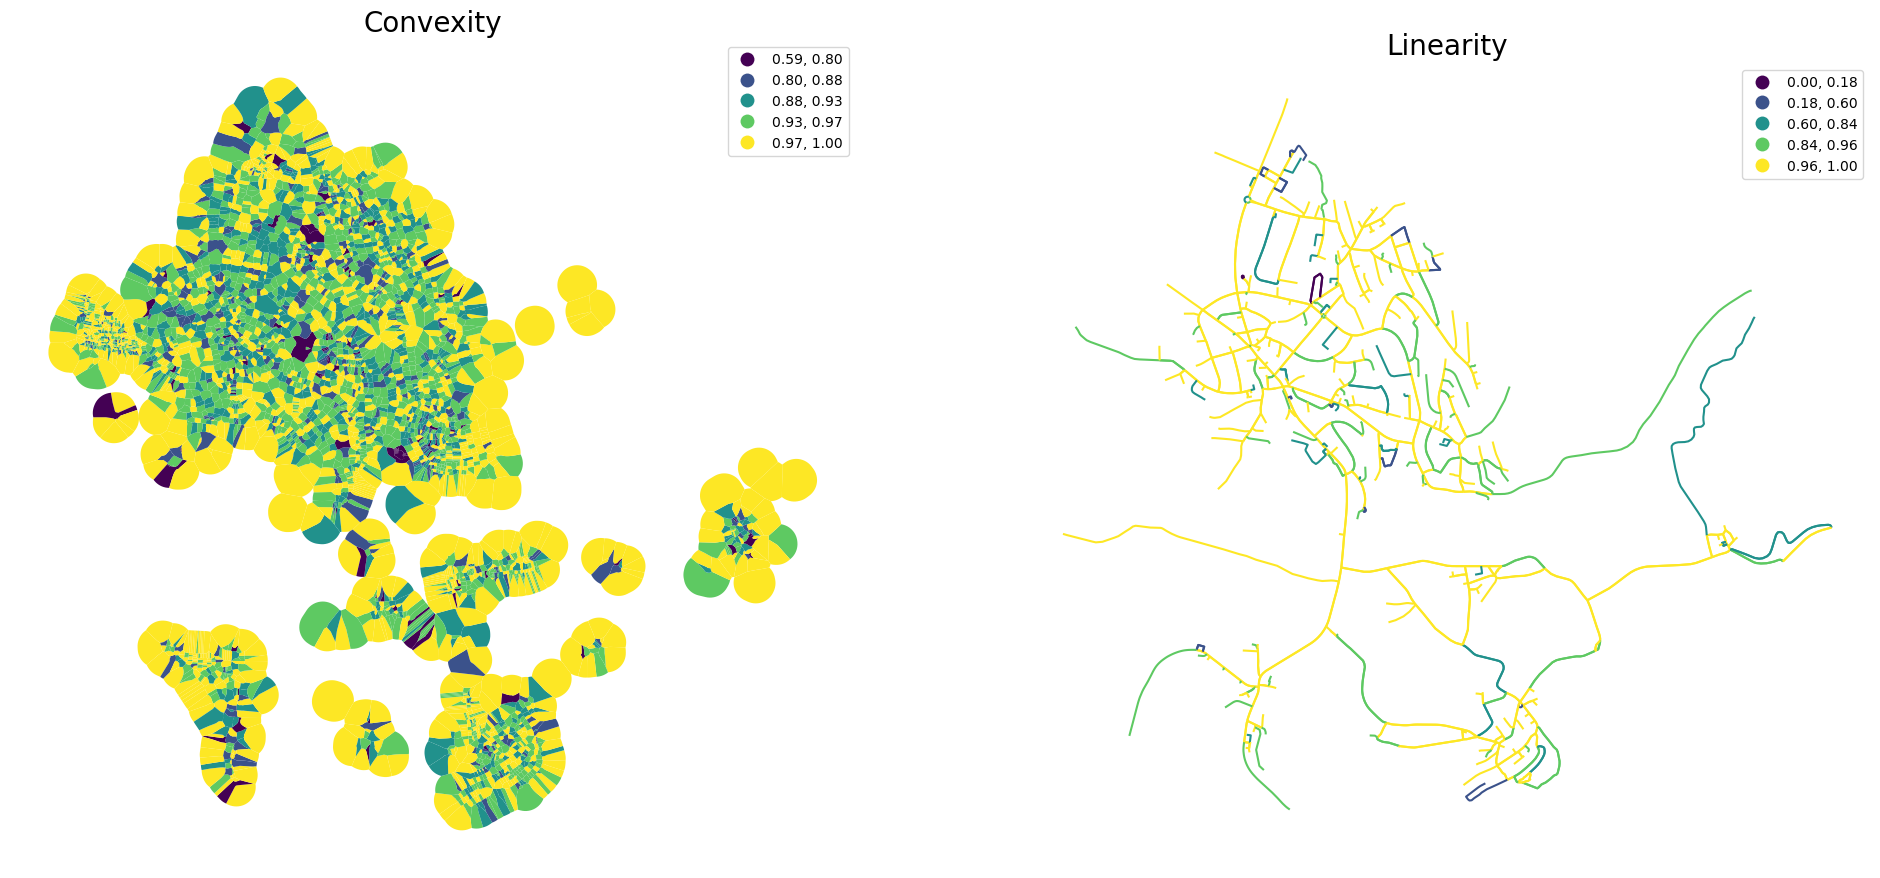

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Linearity', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Seen/convexity_and_linearity.svg')  

### Spatial distribution

In [35]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/momepy/distribution.py:214: FutureWarning: Class based API like `momepy.SharedWalls` or `momepy.SharedWallsRatio` is deprecated. Replace it with `momepy.shared_walls` or explicitly computing `momepy.shared_walls / gdf.length` respectively to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  super().__init__(gdf)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


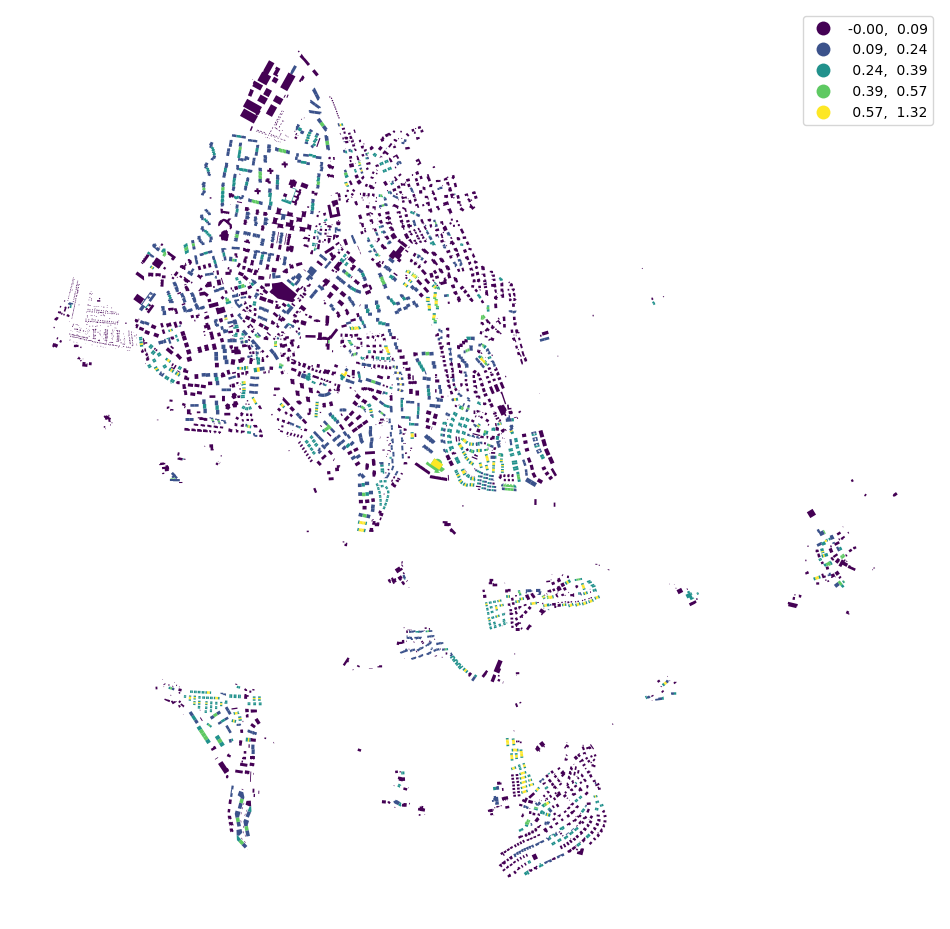

In [36]:
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

plt.savefig('../results/Seen/sharedwalls.svg')  

Generate spatial weights matrix using `libpysal`.

In [37]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [38]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/1669107924.py:1: FutureWarning: Class based API like `momepy.Neighbors` is deprecated. Replace it with `momepy.neighbors` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/1669107924.py:2: FutureWarning: `momepy.CoveredArea` is deprecated. Replace it with `.describe()` method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series


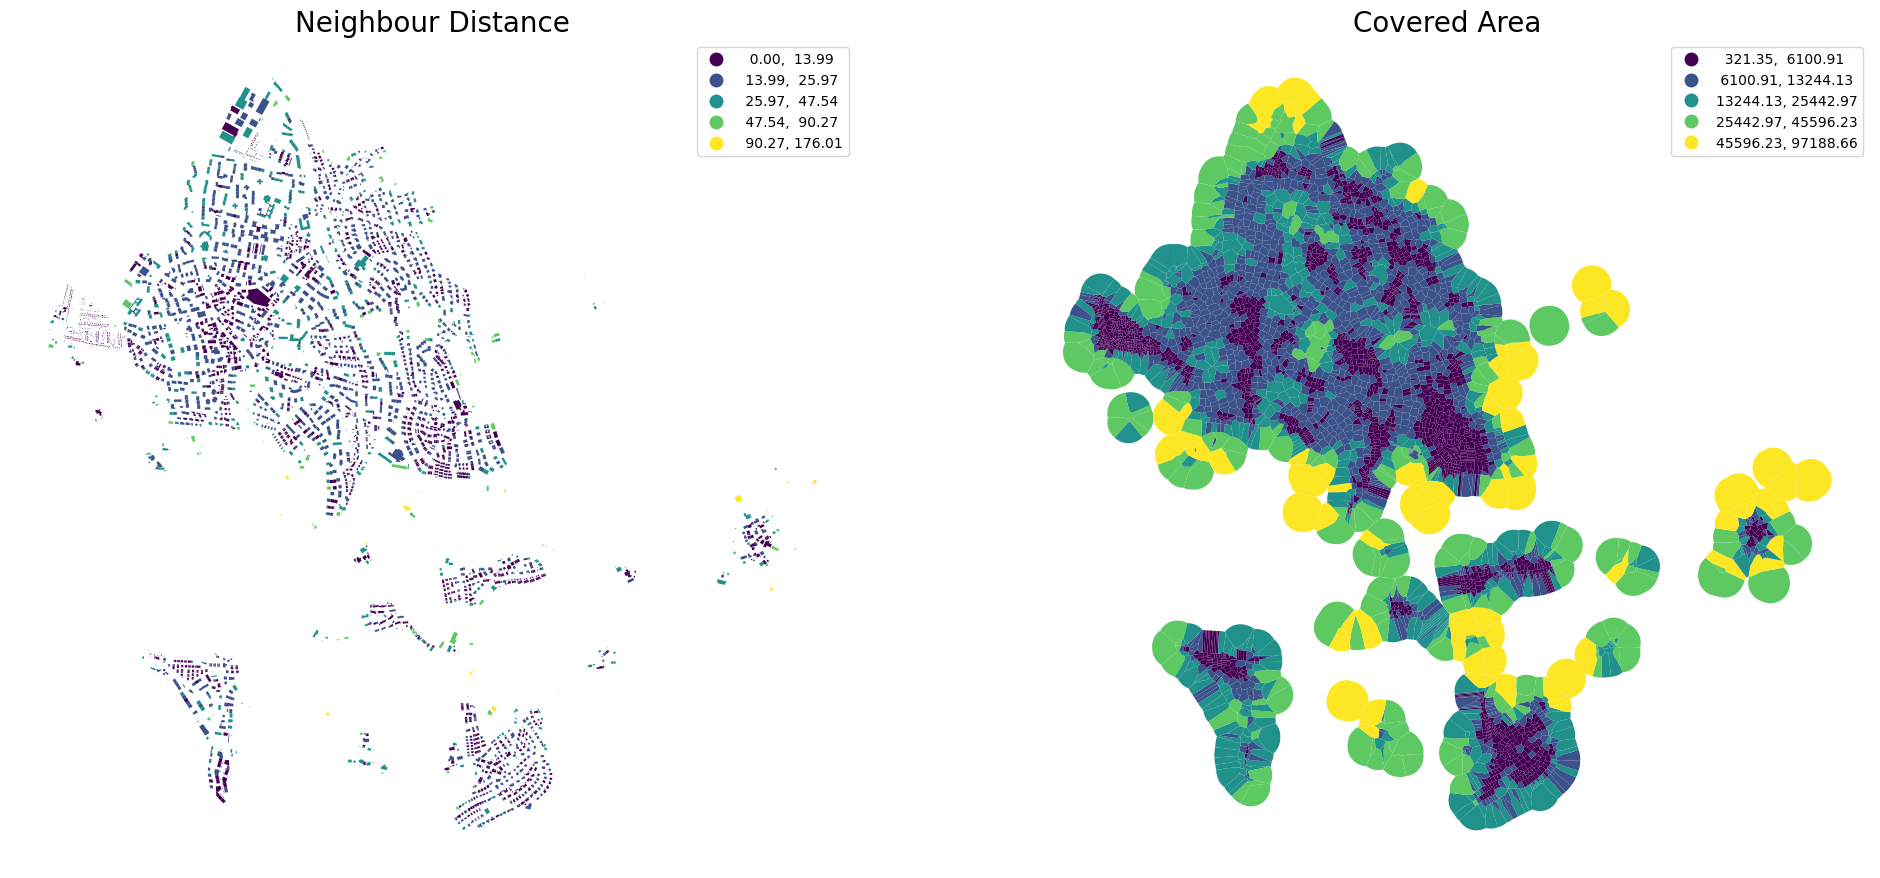

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Neighbour Distance', fontsize=20)
ax[1].set_title('Covered Area', fontsize=20)


ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Seen/neighbourdist_and_coveredarea.svg')  

In [40]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/3221532125.py:1: FutureWarning: `momepy.sw_high` is deprecated. Replace it with .higher_order() method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  queen_3 = momepy.sw_high(k=3, weights=queen_1)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/3221532125.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/3221532125.py:4: FutureWarning: Class based API like `momepy.MeanInterbuildingDistance` is deprecated. Replace it with `momepy.mean_interbuilding_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['interbuilding_distance'] 

In [41]:
#fig, ax = plt.subplots(1, 2, figsize=(24, 12))
#
#buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
#buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)
#
#ax[0].set_axis_off()
#ax[1].set_axis_off()

In [42]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/2648127835.py:1: FutureWarning: Class based API like `momepy.StreetProfile` is deprecated. Replace it with `momepy.street_profile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  profile = momepy.StreetProfile(streets, buildings)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in intersection
  return getattr(ufunc, method)(*new_inputs, **kwargs)


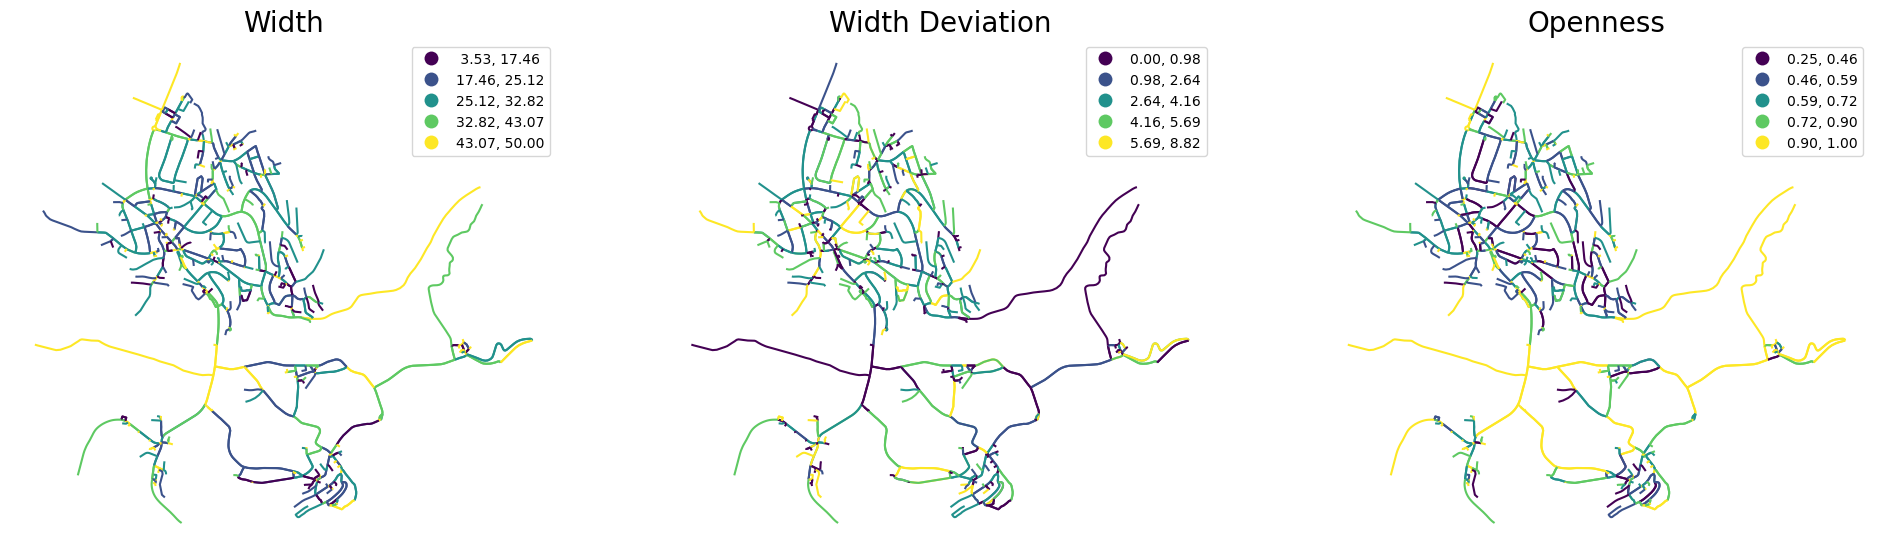

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_title('Width', fontsize=20)
ax[1].set_title('Width Deviation', fontsize=20)
ax[2].set_title('Openness', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Seen/road_network.svg')  

### Intensity

In [44]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/1819725789.py:1: FutureWarning: `momepy.AreaRatio` is deprecated. Replace it with a direct division of areas or momepy.describe_agg() or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series


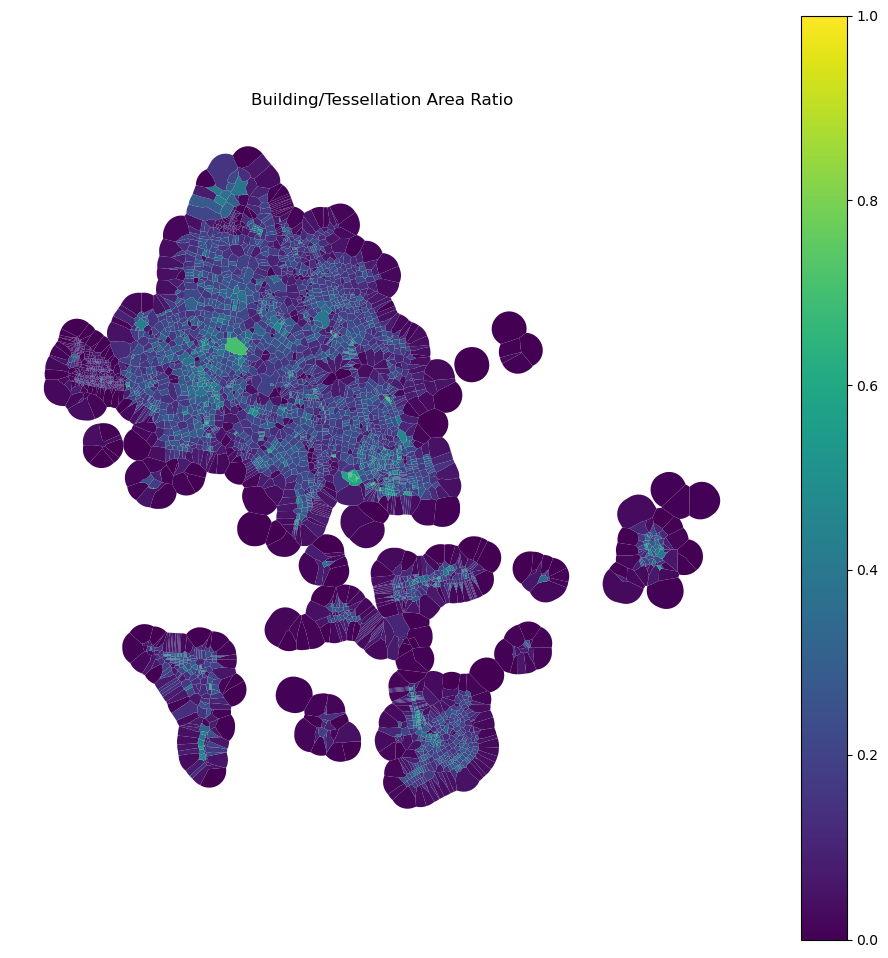

In [45]:
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()
plt.title("Building/Tessellation Area Ratio")

plt.savefig('../results/Seen/tessellation_ratio.svg')  

### Connectivity

In [46]:
graph = momepy.gdf_to_nx(streets)

In [47]:
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")

  0%|          | 0/559 [00:00<?, ?it/s]

  0%|          | 0/559 [00:00<?, ?it/s]

In [48]:
nodes, streets = momepy.nx_to_gdf(graph)

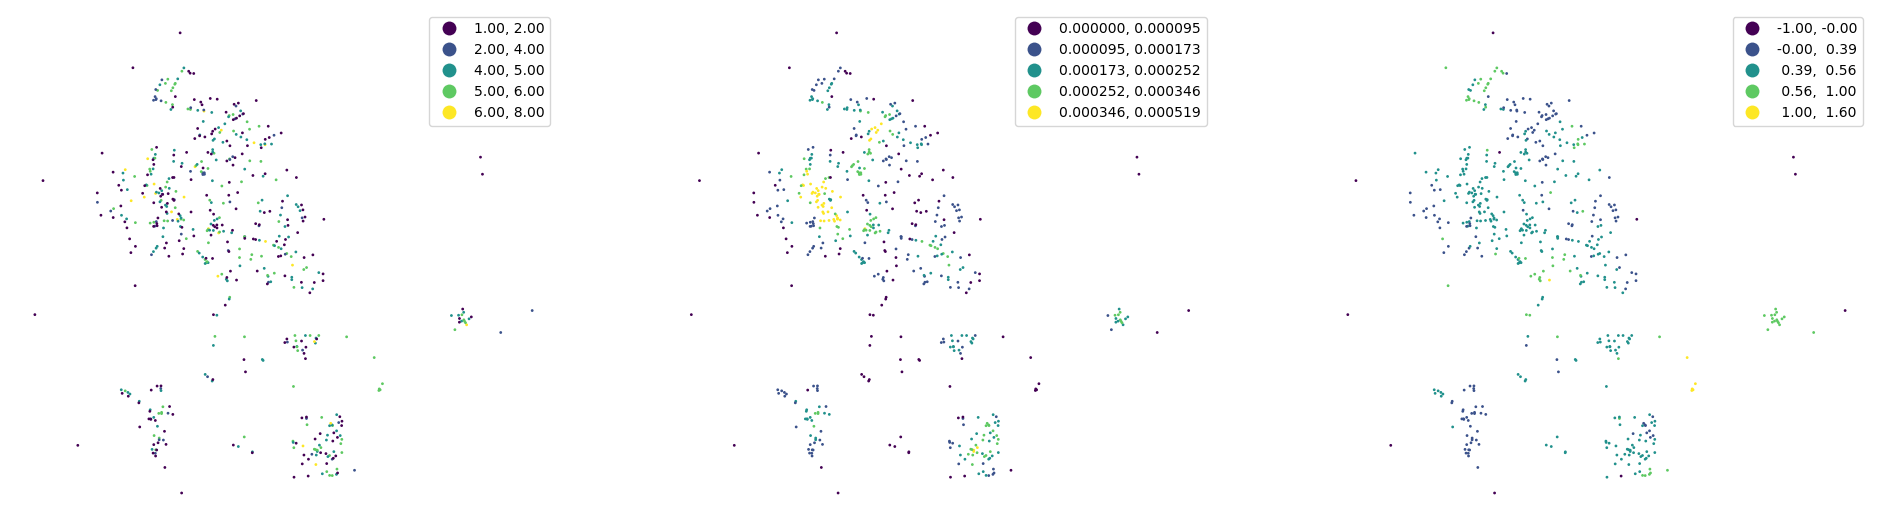

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Seen/connectivity.svg')  

In [50]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/403706460.py:1: FutureWarning: Class based API like `momepy.get_node_id` is deprecated. Replace it with `momepy.get_nearest_node` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")


  0%|          | 0/4197 [00:00<?, ?it/s]

Link all data together (to tessellation cells or buildings).

In [51]:
tessellation

uID                                           geometry   nID  \
0      856  POLYGON ((2700838.791 1257605.825, 2700838.970...  1001   
1     1024  POLYGON ((2700870.019 1257630.182, 2700870.041...  1001   
2      947  POLYGON ((2701078.385 1257619.806, 2701078.107...   664   
3     2116  POLYGON ((2701182.407 1257788.416, 2701181.608...   661   
4     1015  POLYGON ((2701195.315 1257812.690, 2701194.997...   661   
...    ...                                                ...   ...   
4192  3677  POLYGON ((2700411.233 1260725.611, 2700411.713...   421   
4193  3735  POLYGON ((2700368.108 1260752.778, 2700367.817...    21   
4194  3736  POLYGON ((2700361.637 1260791.005, 2700360.139...   421   
4195  3801  POLYGON ((2700354.056 1260905.007, 2700353.979...   958   
4196  2379  POLYGON ((2699776.516 1261314.535, 2699772.528...   891   

              area  convexity  neighbors  covered_area       car  
0      5448.607441   0.957026   0.015275  24254.443041  0.029738  
1      4382.655553   0.923931   0.015191  15588.846523  0.036428  
2     13488.333593   0.964343   0.017872  25344.249944  0.043409  
3      3944.961199   0.985575   0.013325  11583.164402  0.039000  
4      4169.747062   0.957039   0.016099  13134.719446  0.042632  
...            ...        ...        ...           ...       ...  
4192   2417.235404   0.924046   0.034999  25180.847246  0.146726  
4193   1464.962630   0.901722   0.029142  13593.971906  0.133138  
4194   6849.661507   0.963999   0.021092  32118.843743  0.053720  
4195   5191.479919   0.988363   0.022668  37453.584411  0.031018  
4196  14537.189238   0.992985   0.006508  53539.911322  0.002725  

[4197 rows x 8 columns]

In [52]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [53]:
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'x', 'y', 'degree', 'closeness',
       'meshedness'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [54]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_42497/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API

In [55]:
percentiles_joined = pandas.concat(percentiles, axis=1)

In [56]:
percentiles_joined

area_x_25    area_x_50    area_x_75  convexity_25  convexity_50  \
0      473.677373   587.712265  2201.125433      0.930718      0.956597   
1      492.682784   587.712265  1653.334444      0.929710      0.953847   
2      349.587646   531.390393  1267.097654      0.946970      0.959353   
3      565.307449   670.212317  3067.152372      0.944292      0.958990   
4      611.673839   697.041425  3067.152372      0.949803      0.960189   
...           ...          ...          ...           ...           ...   
4192   783.497637  1090.548242  1983.827213      0.936850      0.961643   
4193   747.345521  1090.548242  1819.060988      0.931006      0.959645   
4194   747.345521  1090.548242  2114.502924      0.933676      0.961643   
4195   781.876344  1156.991249  2871.730062      0.943768      0.963999   
4196  3143.020419  4301.867096  7635.290816      0.927987      0.962596   

      convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0         0.983610      0.022094      0.055187      0.061628      6467.183713   
1         0.978524      0.019450      0.053977      0.061066      5299.588117   
2         0.977001      0.046087      0.058317      0.075544      3187.312381   
3         0.965923      0.017722      0.055657      0.065771      4903.351896   
4         0.976542      0.016835      0.056183      0.067984      5077.248055   
...            ...           ...           ...           ...              ...   
4192      0.980523      0.034142      0.043600      0.054249      7122.226893   
4193      0.977730      0.034810      0.043748      0.054612      6933.031353   
4194      0.982022      0.030805      0.043748      0.054612      7204.651092   
4195      0.982456      0.023707      0.041747      0.053956      8004.008905   
4196      0.984845      0.011177      0.020058      0.026881     31449.040870   

      ...          y_75  degree_25  degree_50  degree_75  closeness_25  \
0     ...  1.257692e+06        1.0        1.0        1.0      0.000000   
1     ...  1.257692e+06        1.0        1.0        1.0      0.000000   
2     ...  1.257801e+06        5.0        6.0        6.0      0.000146   
3     ...  1.257896e+06        6.0        6.0        6.0      0.000157   
4     ...  1.257896e+06        6.0        6.0        6.0      0.000190   
...   ...           ...        ...        ...        ...           ...   
4192  ...  1.260791e+06        2.5        6.0        6.0      0.000125   
4193  ...  1.260824e+06        4.0        6.0        6.0      0.000125   
4194  ...  1.260860e+06        1.0        5.0        6.0      0.000125   
4195  ...  1.260915e+06        1.0        5.0        6.0      0.000085   
4196  ...  1.261204e+06        1.0        5.0        6.0      0.000060   

      closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0         0.000000      0.000034      -0.000000       0.000000       0.217391  
1         0.000000      0.000068       0.000000       0.000000       0.434783  
2         0.000225      0.000225       0.491803       0.522388       0.522388  
3         0.000217      0.000217       0.491803       0.491803       0.594527  
4         0.000217      0.000217       0.491803       0.491803       0.491803  
...            ...           ...            ...            ...            ...  
4192      0.000157      0.000171       0.306020       0.529412       0.536585  
4193      0.000157      0.000171       0.320513       0.529412       0.536585  
4194      0.000157      0.000171       0.304348       0.341463       0.536585  
4195      0.000157      0.000175       0.304348       0.333333       0.529412  
4196      0.000107      0.000150       0.478261       0.621922       0.783414  

[4197 rows x 66 columns]

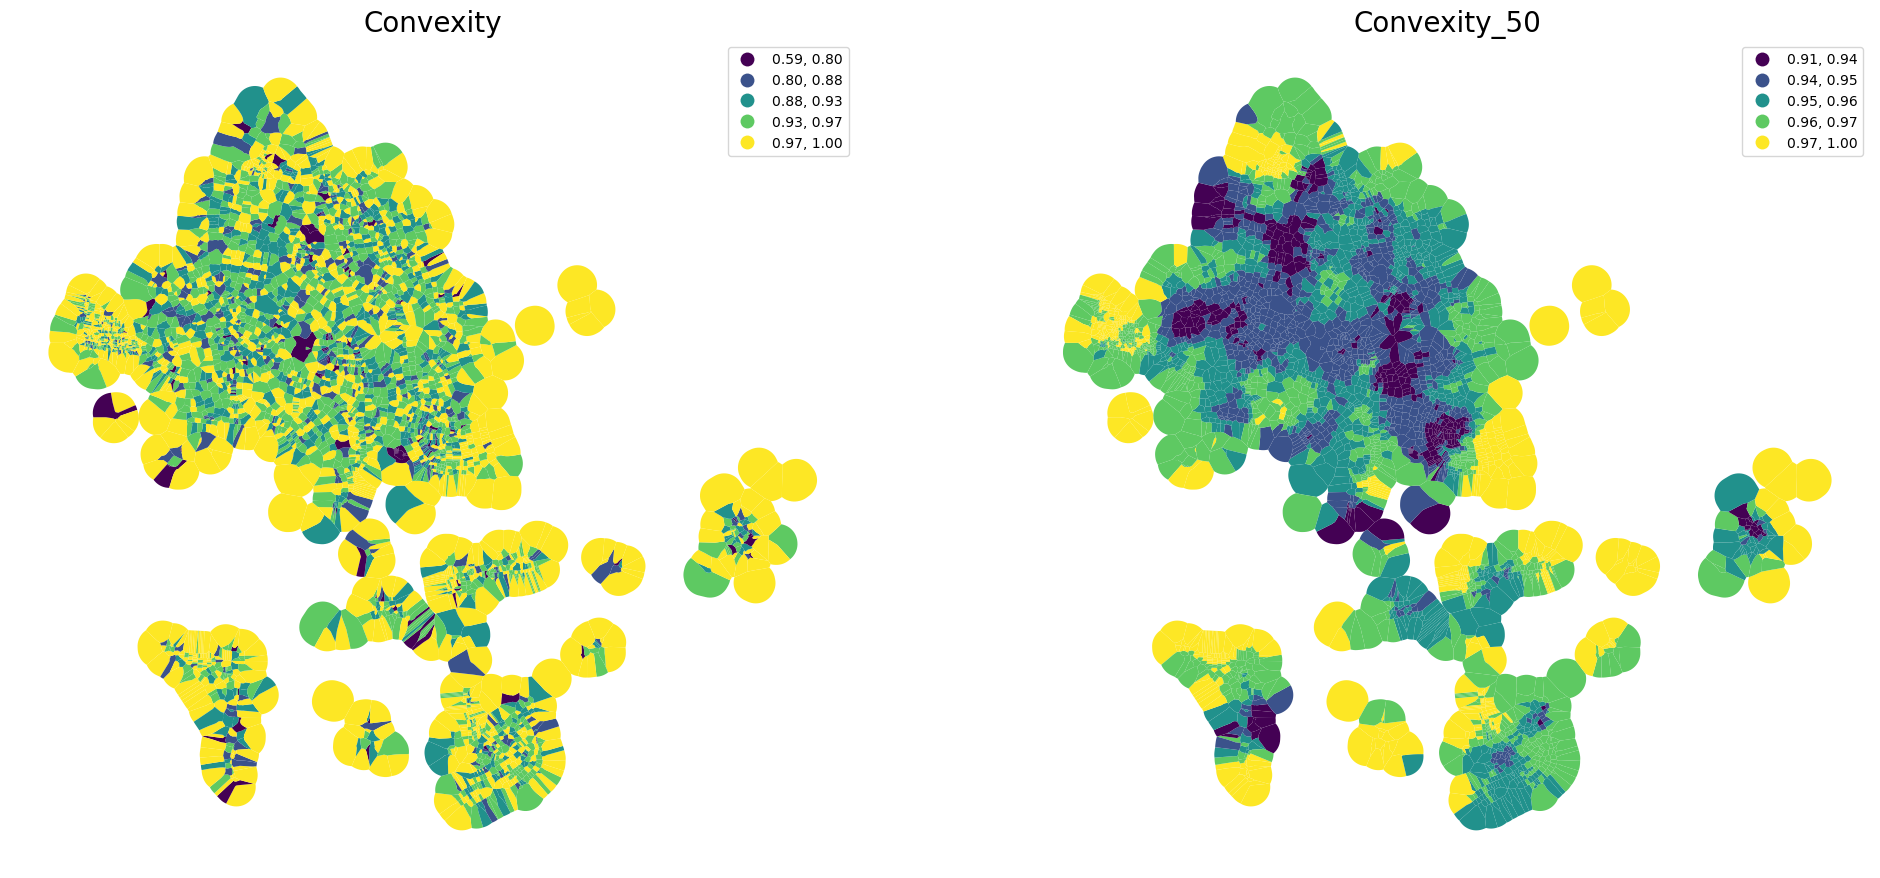

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Convexity_50', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Seen/convexity.svg')  

## Clustering

Standardize values before clustering.

In [58]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()

In [59]:
standardized

area_x_25  area_x_50  area_x_75  convexity_25  convexity_50  \
0     -0.030710  -0.268413   0.296743      0.212464      0.100945   
1     -0.004881  -0.268413  -0.006864      0.160498     -0.124724   
2     -0.199350  -0.325308  -0.220932      1.050429      0.327201   
3      0.093818  -0.185074   0.776729      0.912342      0.297426   
4      0.156831  -0.157972   0.776729      1.196539      0.395800   
...         ...        ...        ...           ...           ...   
4192   0.390343   0.239537   0.176308      0.528655      0.515178   
4193   0.341212   0.239537   0.084988      0.227311      0.351132   
4194   0.341212   0.239537   0.248733      0.364981      0.515178   
4195   0.388140   0.306656   0.668418      0.885368      0.708500   
4196   3.596991   3.483516   3.308570      0.071666      0.593392   

      convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0         1.025688     -1.033640     -0.065038     -0.375738         0.324204   
1         0.415639     -1.168086     -0.118559     -0.396328         0.046216   
2         0.232930      0.186091      0.073329      0.134124        -0.456687   
3        -1.095753     -1.255930     -0.044271     -0.223953        -0.048122   
4         0.177891     -1.301002     -0.021016     -0.142883        -0.006720   
...            ...           ...           ...           ...              ...   
4192      0.655345     -0.421153     -0.577275     -0.646117         0.480160   
4193      0.320371     -0.387185     -0.570734     -0.632787         0.435115   
4194      0.835217     -0.590788     -0.570734     -0.632787         0.499784   
4195      0.887235     -0.951649     -0.659207     -0.656854         0.690100   
4196      1.173779     -1.588661     -1.617979     -1.648828         6.272028   

      ...      y_75  degree_25  degree_50  degree_75  closeness_25  \
0     ... -2.268437  -1.021944  -2.241900  -3.415319     -1.543313   
1     ... -2.268437  -1.021944  -2.241900  -3.415319     -1.543313   
2     ... -2.144858   0.999309   0.841888   0.349578      0.168185   
3     ... -2.035750   1.504622   0.841888   0.349578      0.299038   
4     ... -2.035750   1.504622   0.841888   0.349578      0.684578   
...   ...       ...        ...        ...        ...           ...   
4192  ...  1.270097  -0.263974   0.841888   0.349578     -0.079411   
4193  ...  1.308148   0.493996   0.841888   0.349578     -0.079411   
4194  ...  1.348957  -1.021944   0.225130   0.349578     -0.079411   
4195  ...  1.411151  -1.021944   0.225130   0.349578     -0.542391   
4196  ...  1.741547  -1.021944   0.225130   0.349578     -0.836021   

      closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0        -1.790379     -1.655337      -2.884180      -3.104486      -1.725708  
1        -1.790379     -1.323367      -2.884180      -3.104486      -0.310484  
2         0.581891      0.217531       0.572686       0.528721       0.259831  
3         0.491634      0.133644       0.572686       0.316004       0.729460  
4         0.491634      0.133644       0.572686       0.316004       0.060723  
...            ...           ...            ...            ...            ...  
4192     -0.136368     -0.309431      -0.733177       0.577571       0.352256  
4193     -0.136368     -0.309431      -0.631308       0.577571       0.352256  
4194     -0.136368     -0.309431      -0.744931      -0.729609       0.352256  
4195     -0.136368     -0.269512      -0.744931      -0.786154       0.305555  
4196     -0.666500     -0.518738       0.477496       1.220979       1.959116  

[4197 rows x 66 columns]

### How many clusters?

In [60]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=0)
cgram.fit(standardized.fillna(0))

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.037 seconds.
K=3 fitted in 0.068 seconds.
K=4 fitted in 0.049 seconds.
K=5 fitted in 0.125 seconds.
K=6 fitted in 0.088 seconds.
K=7 fitted in 0.091 seconds.
K=8 fitted in 0.099 seconds.
K=9 fitted in 0.112 seconds.
K=10 fitted in 0.121 seconds.
K=11 fitted in 0.135 seconds.


Clustergram(k_range=range(1, 12), backend='sklearn', method='kmeans', kwargs={'n_init': 10, 'random_state': 0})

In [61]:
show(cgram.bokeh())

In [62]:
cgram.labels.head()

1   2   3   4   5   6   7   8   9   10  11
0   0   0   1   0   3   1   2   4   4   8   8
1   0   0   1   2   2   1   2   4   4   8   8
2   0   0   2   2   2   4   5   5   0   4   1
3   0   0   2   2   2   4   5   5   0   4   1
4   0   0   2   2   2   4   5   5   0   4   1

In [63]:
merged["cluster"] = cgram.labels[8].values

In [64]:
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")

In [65]:
urban_types.explore("cluster", categorical=True, prefer_canvas=True, tiles="CartoDB Positron", tooltip=False)

## Export

Save cluster output geodata to geojson file:

In [66]:
urban_types.to_file('../data/raw/Seen.geojson', driver='GeoJSON')

## Utilities

Once you run the cell below, it hides all cells below the currently active one (aka presentation mode).

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: none;
}
</style>

Run this cell to turn the presentation mode off.

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: block;
}
</style>